# Multilayer Fully-Connected Network

In [1]:
# WARNING: EXPENSIVE COMPUTING IF RUN_CALCULATION = True
# Calculation has already been done and saved in FILEPATH file and are reloaded from the file in this notebook
RUN_CALCULATION = False
GRID_FILEPATH   = 'saved_grid_search_results/fcnn_grid.npy'
MODEL_FILEPATH  = 'saved_best_models/fcnn/fcnn_model.ckpt'

In [2]:
# Import functions used in the different notebooks of the course project
%run Tools.ipynb

In [3]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from sklearn.model_selection import ParameterGrid, StratifiedKFold
from sklearn.preprocessing import StandardScaler

## Load and Split Sets

In [4]:
# Load the overfeat dataset
overfeat, _, labels, names = load_data()

# Check shapes
print('Overfeat shape:', overfeat.shape)
print('Labels shape:', labels.shape)

Overfeat shape: (5000, 4096)
Labels shape: (5000,)


In [5]:
# Split the train/test sets (4000/1000 stratified split)
X_train, X_test, y_train, y_test = split_data_stratified(overfeat, labels, test_size=1000)

# Check shapes
print('Train shape:', X_train.shape, y_train.shape)
print('Test shape:', X_test.shape, y_test.shape)

Train shape: (4000, 4096) (4000,)
Test shape: (1000, 4096) (1000,)


## Stratified Batch Generator

We will train our models with small batches of random choosen images. It sounds a good idea to implement a function that returns a random stratified batch of images to improve the learning process.

In [6]:
# Batch generator
def get_stratified_batches(features, target, batch_size):
    
    # number of classes
    n_classes = len(np.unique(target))
    
    # batch size to accomodate the number of classes and have nice stratified batches
    batch_size = (batch_size // n_classes)
    
    # indices for one class
    idx = np.arange(len(target) // n_classes)
    np.random.shuffle(idx)
    
    # take the same number of observations/target values from each class
    for i in range(0, len(target) // n_classes, batch_size):
        batch_idx = idx[i:i+batch_size]
        
        X_batch = []
        y_batch = []
        
        # for each classes, get the batch_idx observations and target values
        for k in np.unique(target):
            filter = (target == k)
            X_batch.append(features[filter][batch_idx])
            y_batch.append(target[filter][batch_idx])
        
        # aggregate all sub-batches
        yield np.concatenate(X_batch, axis=0), np.concatenate(y_batch, axis=0)

## Build Graph

Our graph is composed of one hidden layer of 64 units with ReLU activation, and of course an input layer of 4096 neurons, one for each features and an output layer of 4 neurons, one for each class. Dropouts with rate of 50% are applied to the 4096 input neurons and the 64 hidden neurons. Large values in the hidden and output weight matrices $W_1$ and $W_2$ are penalized by an $L_2$ regularization term. Our loss function will follow the formulation: 

$$loss = cross-entropy + \alpha[L_2(W_1) + L_2(W_2)]$$

where $\alpha$ is a regularization strength hyperparameter placeholder. 

The gradient descent learning rate and the number of epochs are the two others hyperparameters we have at our disposal to tune the best possible network. What to expect from these hyperparameters ?

* Learning slowly means working more to achieve the same results, so it would be logical to increase the number of epochs when we decrease the learning rate

* The regularization strength allows to manage the bias/variance trade-off (low value => overfitting, high value => underfitting). High $\alpha$ values, so high bias/low variance, should require less epoch to converge

* Learning rate is a discretization step. With too high learning rate, we could never converge towards a minima but with too low value, we could converge towards a local/less optimal minima

In [7]:
graph = tf.Graph()
with graph.as_default():
    
    # Create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 4096], name='X')
    y = tf.placeholder(dtype=tf.int32, shape=[None], name='Y')
    lr = tf.placeholder(dtype=tf.float32, shape=[], name='Lr')
    alpha = tf.placeholder(dtype=tf.float32, shape=[], name='Alpha')
    training = tf.placeholder(dtype=tf.bool, shape=[], name='Training')
    
    # Apply dropout to the input layer
    X = tf.layers.dropout(
        X, 
        rate=0.5, 
        seed=0,
        training=training
    )
    
    # Hidden layer with 64 units and ReLU activation
    hidden = tf.layers.dense(
        X, 64, 
        activation=tf.nn.relu,
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden'
    )
    
    # Apply dropout to the hidden layer
    hidden = tf.layers.dropout(
        hidden, 
        rate=0.5, 
        seed=0,
        training=training
    )
    
    # Output layer
    logits = tf.layers.dense(
        hidden, 4, activation=None,
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='output'
    )

    # Hidden layer weights
    with tf.variable_scope('hidden', reuse=True):
        W1 = tf.get_variable('kernel')
        
    with tf.variable_scope('output', reuse=True):
        W2 = tf.get_variable('kernel')

    # Loss function: mean cross-entropy with regularization
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    l2_term = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)
    loss = mean_ce + alpha * l2_term
    
    # Gradient descent
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(loss)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32, name='Predictions')
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32), name='Accuracy')
    
    # Create a saver to save trained variables later
    saver = tf.train.Saver()

## Network Training - Grid Search with kFold Cross-Validation

In this section, we will tune our hyperparameters by grid-search with k-fold cross-validation.  
We will train the following models:

* learning rate: $10^{-5}$, epochs: 2000, alpha: $10^{-3}$, $10^{-2}$, $10^{-1}$
* learning rate: $10^{-4}$, epochs: 1000, alpha: $10^{-3}$, $10^{-2}$, $10^{-1}$
* learning rate: $10^{-3}$, epochs: 500,  alpha: $10^{-3}$, $10^{-2}$, $10^{-1}$
* learning rate: $10^{-2}$, epochs: 250,  alpha: $10^{-3}$, $10^{-2}$, $10^{-1}$

**For info:**
I first implemented the grid search without cross-validation but I was not confident about the predicted validation accuracies. So, I implemented k-fold cross validation (and waited one full day to obtains results also :).

In an exercice in the course, we saw that standardization is done on the train set (fit_transform method) and then the scaler is used to standardize the validation and test sets (transform method). Here it's different because cross-validation, training and validation standardizations are done at each split. The final network will be trained on the full training data set (4000 observations), standardization (fit_transform) will be done on these 4000 observations and the scaler used to transform the 1000 test data points. I hope its right...

In [8]:
# function to train a network for a set of hyperparamters
# returns:
# - training accuracy values (training curve: accuracy vs epoch)
# - validation accuracy values (validation curve: accuracy vs epoch)
#
def train_network(param_lr, param_alpha, param_epoch):
    # Validation accuracy
    train_acc_values = []
    valid_acc_values = []

    with tf.Session(graph=graph) as sess:
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        
        # Set seed
        np.random.seed(0)

        # Train several epochs
        for epoch in range(param_epoch):
            # Batch accuracy (to compute the training accuracy afterwards)
            batch_acc = []

            # Get batches of data
            for X_batch, y_batch in get_stratified_batches(X_train_cv_rescaled, y_train_cv, 24):
                # Run training and evaluate accuracy
                _, acc_value = sess.run([train_op, accuracy], feed_dict={
                    X: X_batch,
                    y: y_batch,
                    lr: param_lr, # Learning rate
                    training: True, # Apply dropout
                    alpha: param_alpha
                })

                # Save accuracy (current batch)
                batch_acc.append(acc_value)

            # Training accuracy
            train_acc = np.mean(batch_acc)
            train_acc_values.append(train_acc)
        
            # Evaluate validation accuracy
            valid_acc = sess.run(accuracy, feed_dict={
                X: X_valid_cv_rescaled,
                y: y_valid_cv,
                training: False # Do not apply dropout
            })
            valid_acc_values.append(valid_acc)
    
    return train_acc_values, valid_acc_values

In [9]:
# Hyperparameters
alphas = np.logspace(-3, -1, 3)
lrs = np.logspace(-5, -2, 4)

# Grid parameters
grid = ParameterGrid([
    {'lrs': [1e-5], 'epochs': [2000], 'alphas': alphas},
    {'lrs': [1e-4], 'epochs': [1000], 'alphas': alphas},
    {'lrs': [1e-3], 'epochs': [500],  'alphas': alphas},
    {'lrs': [1e-2], 'epochs': [250],  'alphas': alphas}]
)

# Grid search calculation if not already computed previously or forced
if RUN_CALCULATION | (os.path.exists(GRID_FILEPATH) == False):
    
    # Stratified K-Fold (3200 train/800 validation => 5 folds)
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, random_state=0)
    
    # Progress indicator
    n_steps = len(grid) * n_splits
    i = 1
    
    # Grid search
    scores = []
    for params_dict in grid:
        
        # initialization of the mean train/validation accuracy curves across folds
        params_dict['train_acc_values'] = [0] * params_dict['epochs']
        params_dict['valid_acc_values'] = [0] * params_dict['epochs']
        
        # cross-validation
        split = 0
        for idx_train, idx_valid in skf.split(X_train, y_train):
    
            # training set
            X_train_cv = X_train[idx_train]
            y_train_cv = y_train[idx_train]
        
            # validation set
            X_valid_cv = X_train[idx_valid]
            y_valid_cv = y_train[idx_valid]
            
            # rescale data
            scaler = StandardScaler()
            X_train_cv_rescaled = scaler.fit_transform(X_train_cv)
            X_valid_cv_rescaled = scaler.transform(X_valid_cv)
        
            # print progress status
            print('{} | {}/{} | Split {} | Learning rate {}, Alpha {}, Epoch {}'.format(
                datetime.datetime.now().time(),
                i, 
                n_steps,
                split + 1,
                params_dict['lrs'],
                params_dict['alphas'],
                params_dict['epochs']
            ))
            i += 1
        
            # network training
            train_acc_values, valid_acc_values = train_network(
                param_lr=params_dict['lrs'], 
                param_alpha=params_dict['alphas'], 
                param_epoch=params_dict['epochs']
            )
            
            # store current split training and validation accuracies with the hyperparameters
            params_dict['train_acc_values_split_{}'.format(split)] = train_acc_values
            params_dict['valid_acc_values_split_{}'.format(split)] = valid_acc_values
            
            # we will have to compute the means training & validation curves across all split
            # so, we add them together first
            params_dict['train_acc_values'] = [sum(x) for x in zip(train_acc_values, params_dict['train_acc_values'])]
            params_dict['valid_acc_values'] = [sum(x) for x in zip(valid_acc_values, params_dict['valid_acc_values'])]
            
            split += 1
            
        # compute the mean training and validation accuracy curves
        params_dict['train_acc_values'] = [x / n_splits for x in params_dict['train_acc_values']]
        params_dict['valid_acc_values'] = [x / n_splits for x in params_dict['valid_acc_values']]
        
        # store grid-search results
        scores.append(params_dict)
        
    # Save results in a numpy file
    np.save(GRID_FILEPATH, scores)
else:
    # Load the grid scores results from file
    scores = list(np.load(GRID_FILEPATH, allow_pickle=True))

## Network Selection 

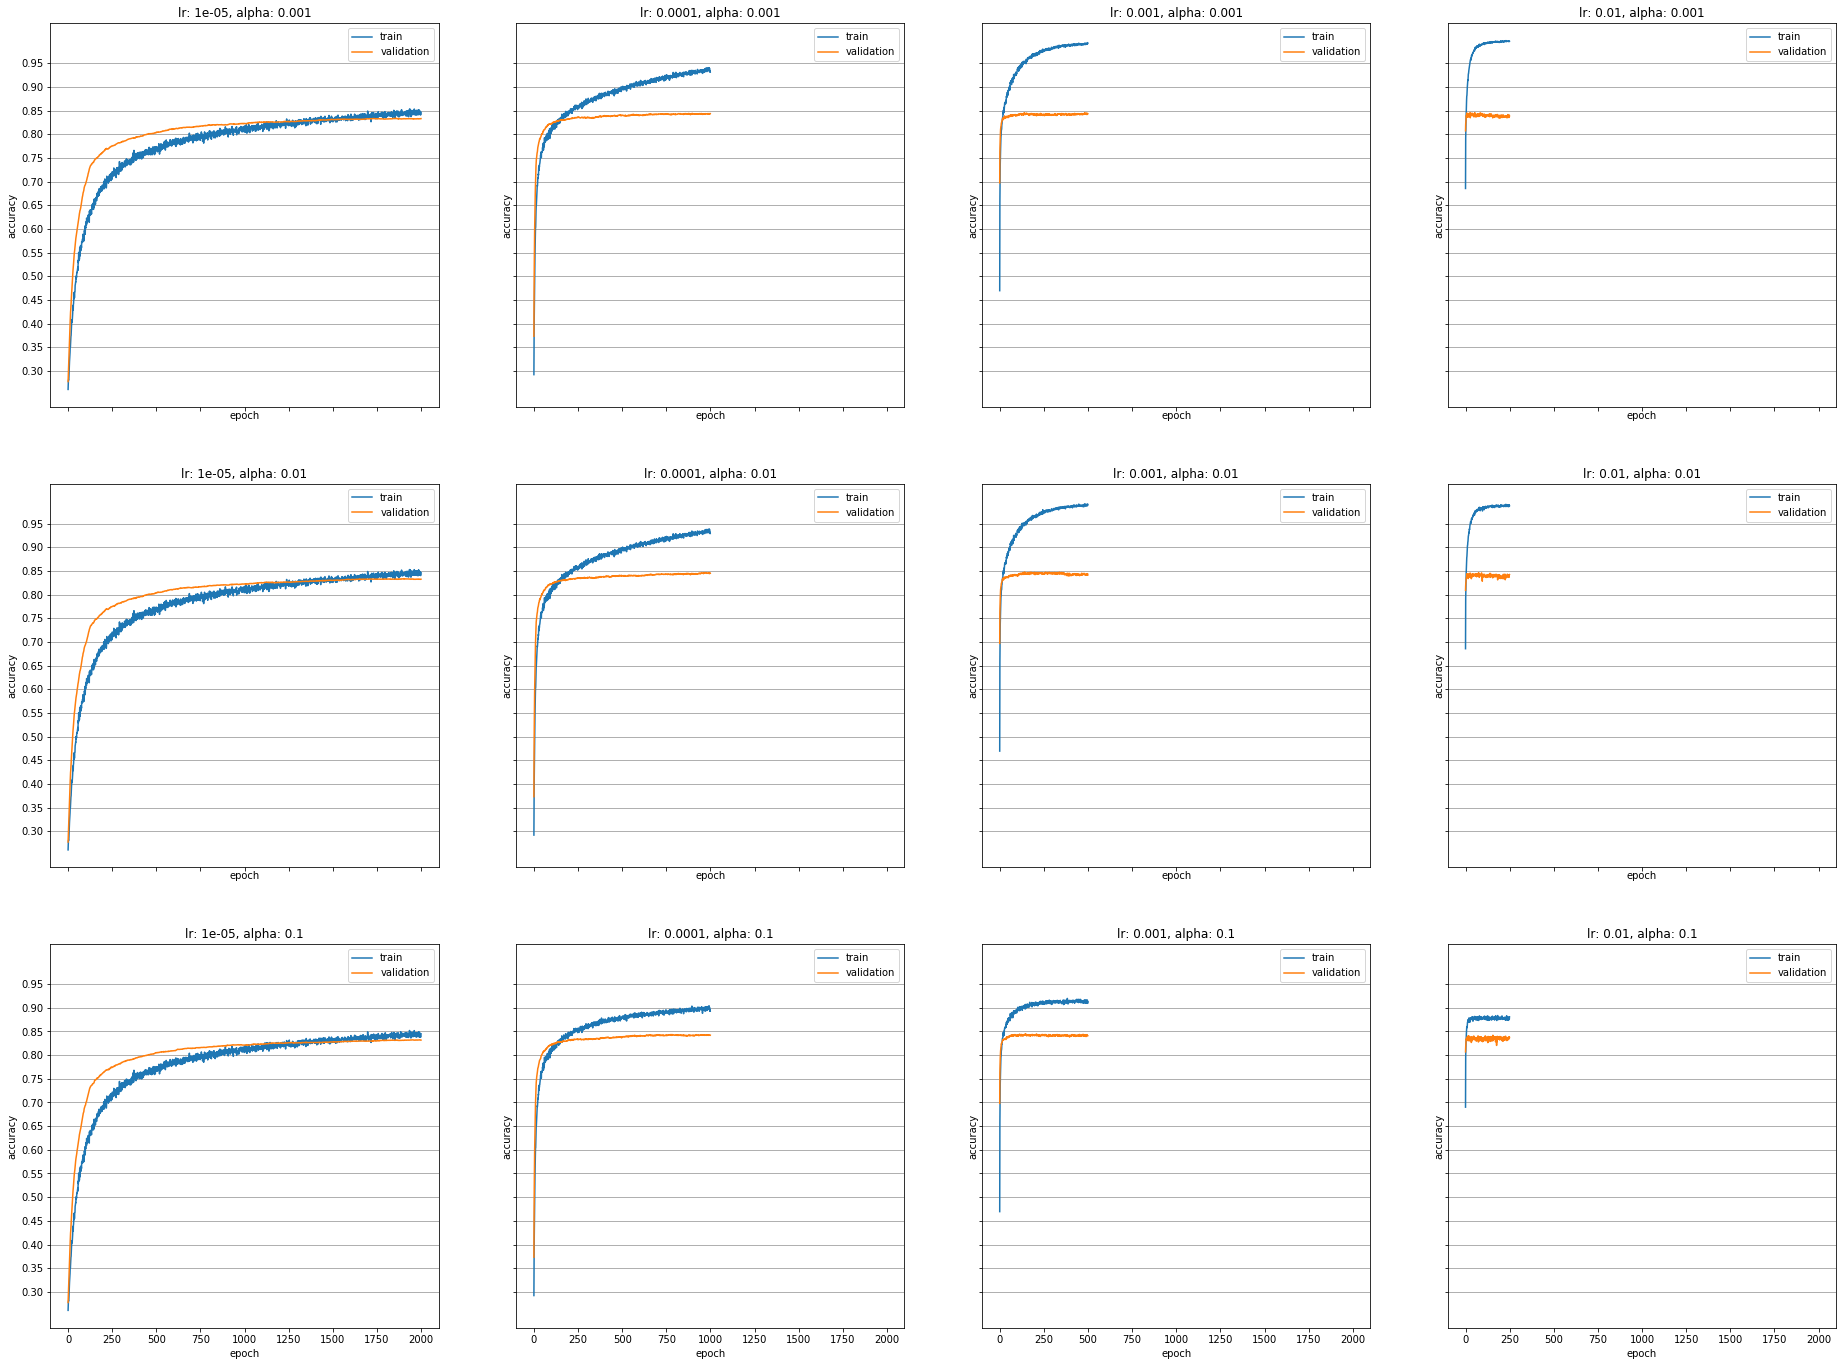

In [10]:
# Plot the training & validation curves for each network
# rows: alpha increasing
# columns: learning rate increasing
fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(32, 24))
for i, param_alpha in enumerate(alphas):
    for j, param_lr in enumerate(lrs):
        model = [model for model in scores if (model['alphas'] == param_alpha) & (model['lrs'] == param_lr)][0]
        ax[i, j].plot(model['train_acc_values'], label='{}'.format('train'))
        ax[i, j].plot(model['valid_acc_values'], label='{}'.format('validation')) 
        ax[i, j].set(
            xlabel='epoch',
            ylabel='accuracy',
            title='lr: {}, alpha: {}'.format(param_lr, param_alpha),
            yticks=np.arange(0.3, 1, 0.05)
        )
        ax[i, j].grid(axis='y', linestyle='-', linewidth=1)
        ax[i, j].legend()
        
plt.show()

Here, we have plot the training and validation curves obtained for each network. From top to bottom, the regularization strength increases, from left to right, the learning rate increases (and the number of epoch decreases because it was not necessary to compute 2000 epoch for each one).

First, all the networks give a validation accuracy between 83%-85% but some looks better than other to achieve similar results. 

One apparent thing is the jitter of the validation curves. From left to right, with increasing learning rates, we can see that the validation curves have more and more jitter. It is very obvious in the most right pannels and indicates too high learning rate. Note that the jitter of the training curves follow the inverse pattern, lower is the learning rate, stronger seems the jitter.

Of course, we can also see the impact of the regularization strength by looking at the panels from top to bottom, same learning rate but with increasing regularization strength. Lower is the regularization strength, quicker/stronger is the overfitting.

But maybe, the most interesting pattern to observe is that given a regularizarion strength (same row), lower is the learning rate, lower is also the overfitting. Training curves looks very similar to the validation curves for learning rate $10^{-5}$.

It is tempting to go ahead with one of these slowest learning rate network. However, we can notice that it seems to converge towards a validation accuracy lower than the model with $10^{-4}$ learning rate and $10^{-2}$ regularization strength (more epoch would have been better to see if the curve continue to grow or stabilized/decrease then).

I am note really sure how to interpret the training/validation curve jitters but I have the feeling that if too high, we can never converge to a solution/minima, if too low, we could converge towards a less optimal solution and it could be what we are observing in the more left column pannel (lower validation accuracy and more training jitter).

So because we have applied cross-validation, we will go ahead a select the network with $10^{-4}$ learning rate and $10^{-2}$ regularization strength. It has sensibly less overfitting than the one with $10^{-3}$ learning rate and $10^{-2}$ regularization strength (~250 epoch) that could also be a good candidate. Note that without cross-validation, I would have select the network with a learning rate of $10^{-5}$.

Let's plot the network curves bigger with mean validation accuracy over the last 50 points:

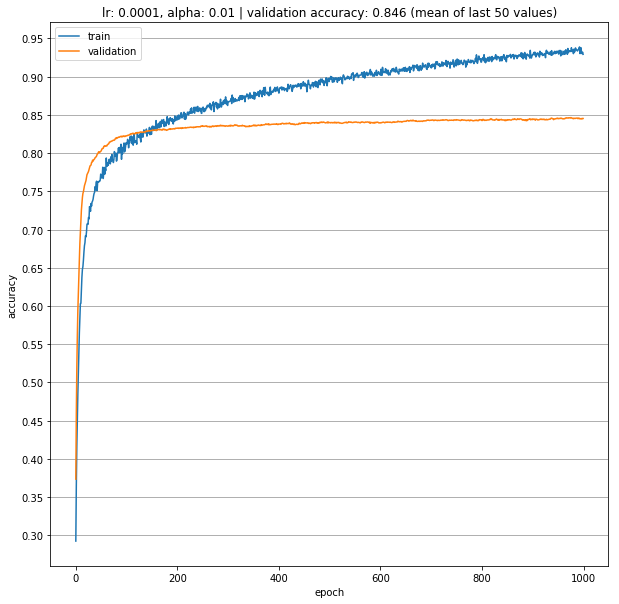

In [11]:
model = [model for model in scores if (model['alphas'] == 1e-2) & (model['lrs'] == 1e-4)][0]

plt.figure(figsize=(10, 10))
plt.plot(model['train_acc_values'], label='{}'.format('train'))
plt.plot(model['valid_acc_values'], label='{}'.format('validation')) 
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('lr: {}, alpha: {} | validation accuracy: {:.3f} (mean of last 50 values)'.format(1e-4, 1e-2, np.mean(model['valid_acc_values'][-50:])))
plt.yticks(np.arange(0.3, 1, 0.05))
plt.grid(axis='y', linestyle='-', linewidth=1)
plt.legend()
plt.show()

# Final Model Training and Test Accuracy

Now that we have selected the hyperparameters to use, let's build our final network with the 4000 training observations and evaluate it on the test set.

Here are the hyperparameters used:

* learning rate: $10^{-4}$
* epoch: 1000
* regularization strength: $10^{-2}$

In [12]:
# Standardization
scaler = StandardScaler()
X_train_rescaled = scaler.fit_transform(X_train)
X_test_rescaled = scaler.transform(X_test)

# Best network training if forced
if RUN_CALCULATION | (os.path.exists(MODEL_FILEPATH + '.index') == False):

    param_epoch = 1000
    param_lr = 1e-4
    param_alpha = 1e-2

    with tf.Session(graph=graph) as sess:
        
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        
        # Set seed
        np.random.seed(0)

        # Train several epochs
        for epoch in range(param_epoch):
            
            # Get batches of data
            for X_batch, y_batch in get_stratified_batches(X_train_rescaled, y_train, 24):
                # Training
                _ = sess.run(train_op, feed_dict={
                    X: X_batch,
                    y: y_batch,
                    lr: param_lr, # Learning rate
                    training: True, # Apply dropout
                    alpha: param_alpha
                })
            
        # Evaluate test accuracy
        test_acc = sess.run(accuracy, feed_dict={
            X: X_test_rescaled,
            y: y_test,
            training: False
        })
        
        # Save training
        saver.save(sess, MODEL_FILEPATH)
else:
    # Load the network from file
    with tf.Session(graph=graph) as sess:
        # load trained variables
        saver.restore(sess, MODEL_FILEPATH)
    
        # evaluate test accuracy
        test_acc = sess.run(accuracy, feed_dict={
            X: X_test_rescaled,
            y: y_test,
            training: False
        })

INFO:tensorflow:Restoring parameters from saved_best_models/fcnn/fcnn_model.ckpt


In [13]:
print('Multilayer fully-connected network accuracy (test set): {:.3f}'.format(test_acc))

Multilayer fully-connected network accuracy (test set): 0.838


Not far from the validation accuracy predicted by cross-validation and a little bit lower than the accuracy obtained by our SVM models. It is probably possible to tune better the hyperparameters and find a better multilayer network.